# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
from collections import defaultdict
import re

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from scipy.stats import linregress

In [3]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [4]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [5]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [6]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
FREQ=60
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [7]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [8]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [9]:
NUM_LINES = 3

In [10]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [11]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "orange",
 'lose_baseline': LOSING_COLORS[0],
 'omission': "red",
 'omission_baseline': "hotpink",
 'rewarded': "green",
 'rewarded_baseline': REWARDED_COLORS[0],
 'win': "blue",
 'win_baseline': WINNING_COLORS[0]}

In [12]:
BASELINE_OUTCOME_TO_COLOR = {'lose_trial': "orange",
 'lose_baseline': LOSING_COLORS[0],
 'omission_trial': "red",
 'omission_baseline': "hotpink",
 'rewarded_trial': "green",
 'rewarded_baseline': REWARDED_COLORS[0],
 'win_trial': "blue",
 'win_baseline': WINNING_COLORS[0]}

In [13]:
COMPETITIVE_OUTCOME_TO_COLOR = {'lose_comp': "orange", 
'lose_non_comp': "yellow",
'omission': "red",
'rewarded': "green",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [14]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [15]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [16]:
all_session_dir = ['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

In [17]:
all_session_dir

['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [18]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [19]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [20]:
CHANNEL_MAPPING_DF

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,NaN,15,14,13,31,21.0,15.0,14.0,13.0,16.0
1,1,6.2,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
2,1,6.3,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
3,1,6.4,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
4,2,1.1,NaN,16,17,18,19,5.0,31.0,30.0,29.0,28.0
5,2,1.2,NaN,31,30,29,28,10.0,31.0,30.0,29.0,28.0
6,2,1.3,NaN,15,14,13,12,9.0,31.0,30.0,29.0,28.0
7,2,1.4,NaN,15,14,13,12,15.0,31.0,30.0,29.0,28.0


### Getting the subject IDs from the file name

In [21]:
TONE_TIMESTAMP_DF = pd.read_pickle("./proc/melted_trials_and_video.pkl")


In [22]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [23]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 0, 1, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[1, 1, 0, 0, 0, 1, 2, 0, 1, 1]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 1, 0, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [24]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [25]:
all_trials_df["recording_dir"].unique()

array(['20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1'],
      dtype=object)

- Getting a list of all the subjects through the recording name

In [26]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [27]:
all_trials_df["all_subjects"].head()

0    [1.4, 1.1]
1    [1.4, 1.1]
2    [1.4, 1.1]
3    [1.4, 1.1]
4    [1.4, 1.1]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [28]:
all_trials_df["subject_info"].head()

0    1_1_t1b2L_box2
1    1_1_t1b2L_box2
2    1_1_t1b2L_box2
3    1_1_t1b2L_box2
4    1_1_t1b2L_box2
Name: subject_info, dtype: object

In [29]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [30]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 0, 1, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[1, 1, 0, 0, 0, 1, 2, 0, 1, 1]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 1, 0, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [31]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [32]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 0, 1, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[1, 1, 0, 0, 0, 1, 2, 0, 1, 1]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 1, 0, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [33]:
competition_closeness_map = {k: "non_comp" if "only" in str(k).lower() else "comp" if type(k) is str else np.nan for k in all_trials_df["competition_closeness"].unique()}

In [34]:
competition_closeness_map

{'Subj 2 Only': 'non_comp',
 'Subj 1 Only': 'non_comp',
 'Subj 2 blocking Subj 1': 'comp',
 'Subj 1 then Subj 2': 'comp',
 'Subj 1 blocking Subj 2': 'comp',
 'Subj 2 then Subj 1': 'comp',
 nan: nan}

In [35]:
all_trials_df["competition_closeness"] = all_trials_df["competition_closeness"].map(competition_closeness_map)

In [36]:
all_trials_df["competition_closeness"]

0      non_comp
1      non_comp
2      non_comp
3      non_comp
4      non_comp
         ...   
299         NaN
300         NaN
301         NaN
302         NaN
303         NaN
Name: competition_closeness, Length: 304, dtype: object

In [37]:
all_trials_df["competition_closeness"] = all_trials_df.apply(lambda x: "_".join([str(x["trial_outcome"]), str(x["competition_closeness"])]).strip("nan").strip("_"), axis=1)

### Extracting the LFP

In [38]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in all_session_dir:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, "*.rec")):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id="ECU")
            current_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
            print(recording_basename)
            # Preprocessing the LFP
            current_recording = sp.bandpass_filter(current_recording, freq_min=0.5, freq_max=300)
            current_recording = sp.notch_filter(current_recording, freq=60)
            current_recording = sp.resample(current_recording, resample_rate=1000)
            current_recording = sp.zscore(current_recording)
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except:
            pass



20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
20221215_145401_comp_amd_om_6_1_top_4_base_3
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged


- Filtering for all trials that have labels

In [39]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_name_to_all_ch_lfp.keys())].reset_index(drop=True)

In [40]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 0, 1, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[1, 1, 0, 0, 0, 1, 2, 0, 1, 1]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 1, 0, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [41]:
all_trials_df["trial_outcome"].unique()

array(['lose', 'win', 'rewarded', 'omission'], dtype=object)

In [42]:
all_trials_df["trial_or_baseline"].unique()

array(['baseline', 'trial'], dtype=object)

In [43]:
recording_name_to_all_ch_lfp.keys()

dict_keys(['20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged', '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', '20221215_145401_comp_amd_om_6_1_top_4_base_3', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged'])

In [44]:
CHANNEL_MAPPING_DF

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,NaN,15,14,13,31,21.0,15.0,14.0,13.0,16.0
1,1,6.2,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
2,1,6.3,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
3,1,6.4,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
4,2,1.1,NaN,16,17,18,19,5.0,31.0,30.0,29.0,28.0
5,2,1.2,NaN,31,30,29,28,10.0,31.0,30.0,29.0,28.0
6,2,1.3,NaN,15,14,13,12,9.0,31.0,30.0,29.0,28.0
7,2,1.4,NaN,15,14,13,12,15.0,31.0,30.0,29.0,28.0


## Power Correlation Calculation

In [45]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 0, 1, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[1, 1, 0, 0, 0, 1, 2, 0, 1, 1]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 1, 0, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


- Adding all the brain region to ch information

In [46]:
channel_map_and_all_trials_df = all_trials_df.merge(CHANNEL_MAPPING_DF, left_on="current_subject", right_on="Subject", how="left")

- Linking up all LFP calculations with all the trials

In [47]:
channel_map_and_all_trials_df["all_ch_lfp"] = channel_map_and_all_trials_df["recording_file"].map(recording_name_to_all_ch_lfp)

In [48]:
channel_map_and_all_trials_df

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD,all_ch_lfp
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,16,17,18,19,5.0,31.0,30.0,29.0,28.0,ZScoreRecording: 32 channels - 1 segments - 1....
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,16,17,18,19,5.0,31.0,30.0,29.0,28.0,ZScoreRecording: 32 channels - 1 segments - 1....
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,16,17,18,19,5.0,31.0,30.0,29.0,28.0,ZScoreRecording: 32 channels - 1 segments - 1....
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,16,17,18,19,5.0,31.0,30.0,29.0,28.0,ZScoreRecording: 32 channels - 1 segments - 1....
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,16,17,18,19,5.0,31.0,30.0,29.0,28.0,ZScoreRecording: 32 channels - 1 segments - 1....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,66660918,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,64158037,20230620_114347_standard_comp_to_omission_D4_s...,64089,1,1-2_t3b3L_box_1,...,31,30,29,28,10.0,31.0,30.0,29.0,28.0,ZScoreRecording: 32 channels - 1 segments - 1....
300,68560944,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,66058063,20230620_114347_standard_comp_to_omission_D4_s...,65986,1,1-2_t3b3L_box_1,...,31,30,29,28,10.0,31.0,30.0,29.0,28.0,ZScoreRecording: 32 channels - 1 segments - 1....
301,68560944,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,66058063,20230620_114347_standard_comp_to_omission_D4_s...,65986,1,1-2_t3b3L_box_1,...,31,30,29,28,10.0,31.0,30.0,29.0,28.0,ZScoreRecording: 32 channels - 1 segments - 1....
302,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,31,30,29,28,10.0,31.0,30.0,29.0,28.0,ZScoreRecording: 32 channels - 1 segments - 1....


- Getting the LFP for trial

In [49]:
channel_map_and_all_trials_df["resampled_index"] = channel_map_and_all_trials_df["resampled_index"].astype(int)

In [50]:
channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"] = channel_map_and_all_trials_df["chunked_lfp_index"].apply(lambda x: (x[0][0], x[-1][-1]))

In [51]:
channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"].head()

0      (44962, 54962)
1      (54962, 64962)
2    (164962, 174962)
3    (174962, 184962)
4    (279962, 289962)
Name: trial_or_baseline_entire_lfp_index, dtype: object

In [52]:
channel_columns = sorted([col for col in channel_map_and_all_trials_df.columns if "spike" in col])

In [53]:
channel_columns

['spike_interface_BLA',
 'spike_interface_LH',
 'spike_interface_MD',
 'spike_interface_mPFC',
 'spike_interface_vHPC']

In [54]:
for col in channel_columns:
    print(col)
    channel_map_and_all_trials_df["{}_trace".format(col.strip("spike_interface").strip("_"))] = channel_map_and_all_trials_df.apply(lambda x: 
x["all_ch_lfp"].get_traces(channel_ids=[str(int(x[col]))], start_frame=x["trial_or_baseline_entire_lfp_index"][0], end_frame=x["trial_or_baseline_entire_lfp_index"][-1] ).T[0][:RESAMPLE_RATE*TRIAL_DURATION], axis=1)

spike_interface_BLA
spike_interface_LH
spike_interface_MD
spike_interface_mPFC
spike_interface_vHPC


In [55]:
trace_columns = [col for col in channel_map_and_all_trials_df.columns if "trace" in col]

In [56]:
trace_columns

['BLA_trace', 'LH_trace', 'MD_trace', 'mPFC_trace', 'vHPC_trace']

In [57]:
channel_map_and_all_trials_df["BLA_trace"].iloc[0].shape

(10000,)

In [58]:
low_freq = 4
high_freq = 12

In [59]:
for region in trace_columns:
    
    region_base_name = "{}".format(region.strip("trace").strip("_"))
    print(region_base_name)
    try:
        multitaper_col = "{}_multitaper".format(region_base_name)
        channel_map_and_all_trials_df[multitaper_col] = channel_map_and_all_trials_df[region].apply(lambda x: Multitaper(time_series=x, sampling_frequency=RESAMPLE_RATE))
    
        connectivity_col = "{}_connectivity".format(region_base_name)
        channel_map_and_all_trials_df[connectivity_col] = channel_map_and_all_trials_df[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
        
        channel_map_and_all_trials_df["{}_frequencies".format(region_base_name)] = channel_map_and_all_trials_df[connectivity_col].apply(lambda x: x.frequencies)

        channel_map_and_all_trials_df["{}_power".format(region_base_name)] = channel_map_and_all_trials_df[connectivity_col].apply(lambda x: x.power().squeeze())

        channel_map_and_all_trials_df["{}_averaged_theta_power".format(region_base_name)] = channel_map_and_all_trials_df["{}_power".format(region_base_name)].apply(lambda x: np.mean(x[low_freq*10:high_freq*10+1]))

    except Exception as e: 
        print(e)

BLA
LH
MD
mPFC
vHPC


In [60]:
trace_columns = [col for col in channel_map_and_all_trials_df.columns if "averaged_theta" in col]

In [61]:
brain_region_pairs = generate_pairs(trace_columns)

In [62]:
brain_region_pairs

[('BLA_averaged_theta_power', 'LH_averaged_theta_power'),
 ('BLA_averaged_theta_power', 'MD_averaged_theta_power'),
 ('BLA_averaged_theta_power', 'mPFC_averaged_theta_power'),
 ('BLA_averaged_theta_power', 'vHPC_averaged_theta_power'),
 ('LH_averaged_theta_power', 'MD_averaged_theta_power'),
 ('LH_averaged_theta_power', 'mPFC_averaged_theta_power'),
 ('LH_averaged_theta_power', 'vHPC_averaged_theta_power'),
 ('MD_averaged_theta_power', 'mPFC_averaged_theta_power'),
 ('MD_averaged_theta_power', 'vHPC_averaged_theta_power'),
 ('mPFC_averaged_theta_power', 'vHPC_averaged_theta_power')]

In [63]:
channel_map_and_all_trials_df["trial_outcome"]

0          lose
1          lose
2           win
3           win
4           win
         ...   
299    omission
300    rewarded
301    rewarded
302    rewarded
303    rewarded
Name: trial_outcome, Length: 304, dtype: object

In [64]:
channel_map_and_all_trials_df["trial_outcome"]

0          lose
1          lose
2           win
3           win
4           win
         ...   
299    omission
300    rewarded
301    rewarded
302    rewarded
303    rewarded
Name: trial_outcome, Length: 304, dtype: object

In [65]:
channel_map_and_all_trials_df["outcome_and_trial_or_baseline"] = channel_map_and_all_trials_df.apply(lambda x: "_".join([x["trial_outcome"], x["trial_or_baseline"]]), axis=1)

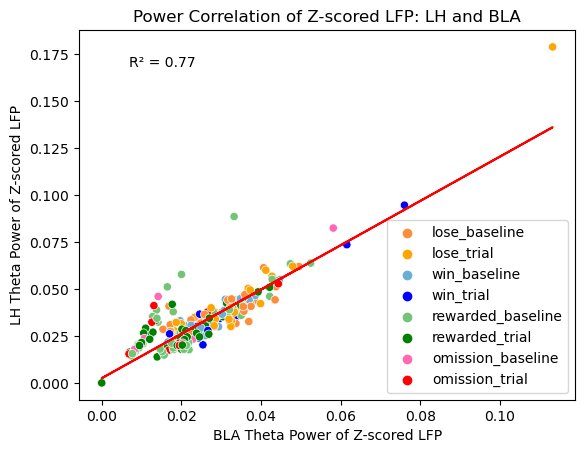

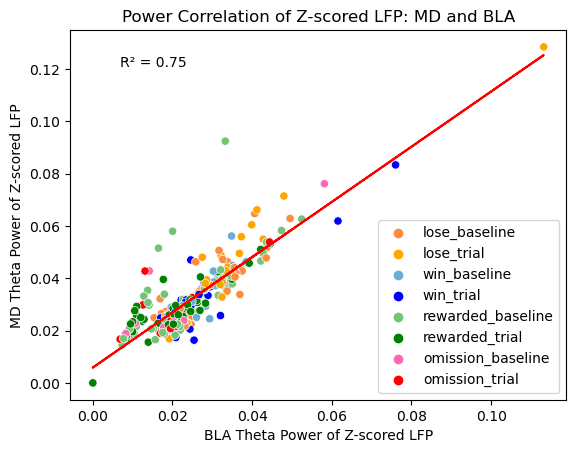

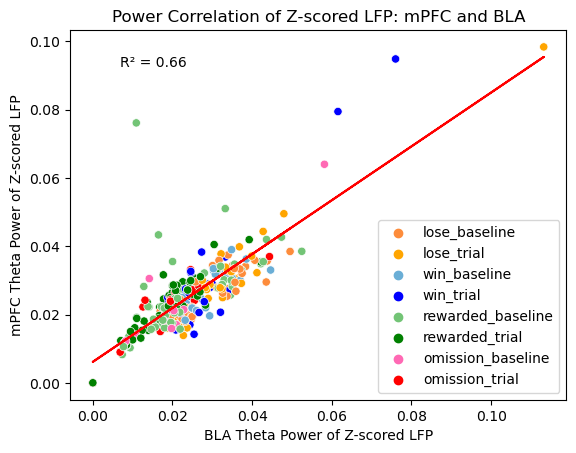

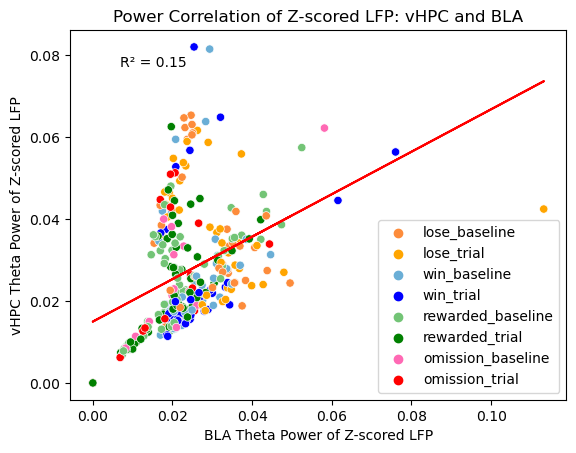

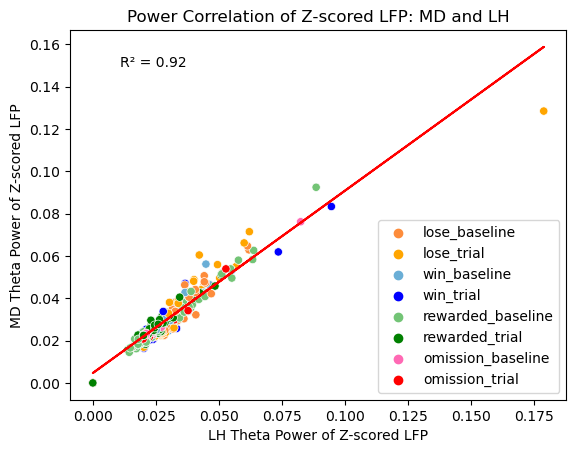

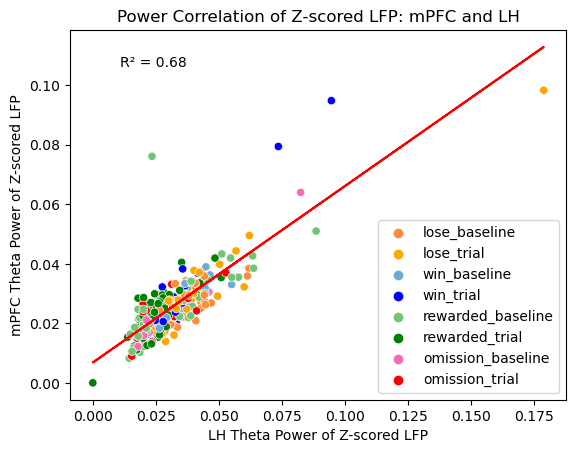

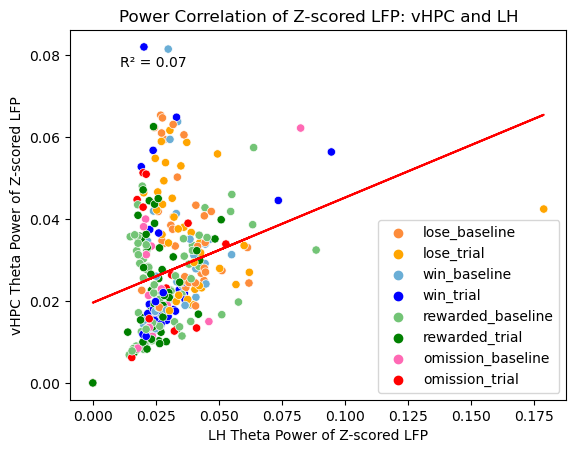

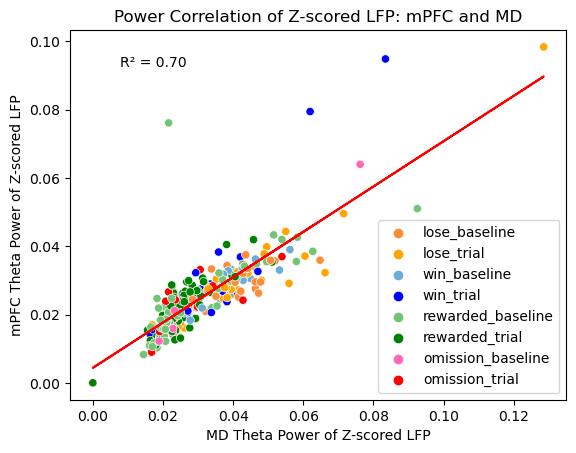

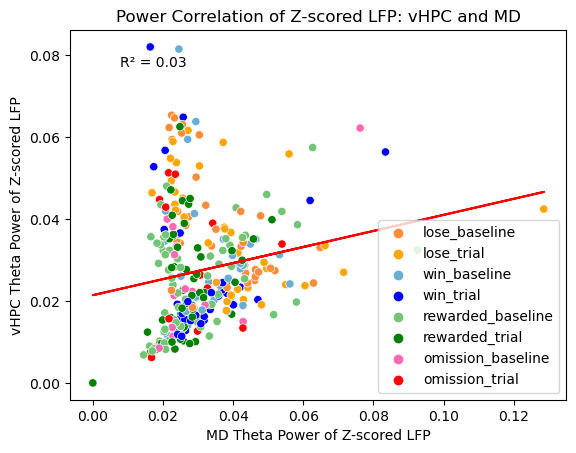

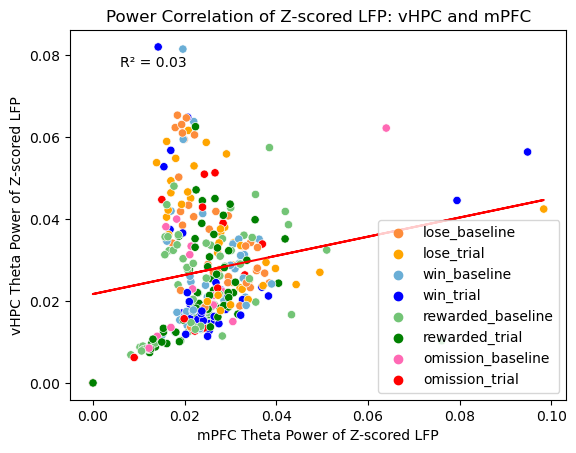

In [66]:
for region_1, region_2 in brain_region_pairs:
    region_1_basename = region_1.split("_")[0]
    region_2_basename = region_2.split("_")[0]
    
    x = channel_map_and_all_trials_df[region_1]
    y = channel_map_and_all_trials_df[region_2]
    
    # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Create a line of best fit using the slope and intercept
    line = slope * x + intercept
    
    # Create scatter plot
    sns.scatterplot(x=x, y=y, data=channel_map_and_all_trials_df, hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR)
    
    # Plot line of best fit
    plt.plot(x, line, color='red')
    
    # Add R² value to the plot
    plt.text(0.1, 0.9, f'R² = {r_value**2:.2f}', transform=plt.gca().transAxes)
    
    # Add labels and legend
    plt.title("Power Correlation of Z-scored LFP: {} and {}".format(region_2_basename, region_1_basename))
    plt.xlabel('{} Theta Power of Z-scored LFP'.format(region_1_basename))
    plt.ylabel('{} Theta Power of Z-scored LFP'.format(region_2_basename))
    plt.legend(loc="lower right")
    plt.savefig("./proc/power_correlation/{}_{}_power_correlation_of_zscored_lfp.png".format(region_1_basename, region_2_basename))
    # Display the plot
    plt.show()
    

In [67]:
raise ValueError()

ValueError: 